In [215]:
from gurobipy import *
import networkx as nx
import matplotlib.pyplot as plt
import random
import warnings
import os
warnings.filterwarnings("ignore")

## Graph Representation

Defintions:
We have a graph $G = (V, E, w)$, where $V = \{1, 2, ..., n\}$, $E$ is the set of edges, and $w$ is the weight of each vertex, the function mapping $V \rightarrow \mathbb{R}^{+}$.

## Drawing Utility

Takes in a undirected graph, and a color map, and draw the graph out in a circular format. 

In [205]:
def draw_reduced(g, color_map = None):
    
    node_lables = nx.get_node_attributes(g, "weight")
    
    if node_lables:
        node_lables = {k: "{0}: {1}".format(k, v) for (k, v) in node_lables.items()}
    else:
        node_lables = {k: k for k in g.nodes}
    
    plt.figure()
    pos = nx.circular_layout(g)
    nx.draw(g, pos, node_size=2000, width = 1, node_color = color_map)
    nx.draw_networkx_labels(g, pos, node_lables)
    plt.show()  
    # plt.savefig("graph.png", dpi=1000)


## Gurobi maximum independent set solver

Takes in a undirected graph, with optional assignment of weight to each vertex. Returns the maximum independent set, computed by the Gurobi solver. 

If using `display=True`, `draw_reduced()` must be supplied.

In [210]:
def compute_max_ind_set(graph, display = False):
    nodes = list(graph.nodes)
    model = Model('Maximum Independent Set')
    
    # Suppress output
    model.setParam('OutputFlag', 0)
    # An indicator variable for whether a node is chosen
    indicators = model.addVars(nodes, vtype=GRB.BINARY, name = "x")
    
    # Set Constraint: If two nodes are bound by an edge, they cannot be both chosen
    model.addConstrs(((indicators[i] + indicators[j] <= 1) for (i, j) in graph.edges), "Max")
    
    # Set objective: Maximize the weighted sum of nodes, or if no weights, just the cardinality.
    weights = nx.get_node_attributes(graph, "weight")
    if weights:
        obj = sum([indicators[i] * weights[i] for i in nodes])
    else:
        obj = sum([indicators[i] for i in nodes])
        
    model.setObjective(obj, GRB.MAXIMIZE)
    model.optimize()
    
    # Find all selected nodes and save them in soln
    soln = []
    for i in range(len(indicators)):
        if indicators[i].x != 0:
            soln.append(i)
    
    if display:
        # Create color map from selected nodes, green for selected, grey for unselected.
        color_map = ["grey"] * len(graph.nodes)
        for i in soln:
            color_map[i] = "green"
        draw_reduced(graph, color_map)
    return soln

### One example: Random Binomial Graph

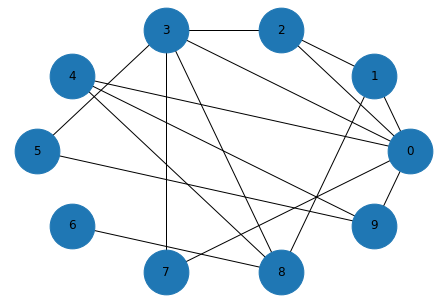

In [211]:
# Generate a random sparse graph and assign random weights to each vertex


rand_graph = nx.fast_gnp_random_graph(10, 0.4, directed=False)

# for v in rand_graph.nodes():
#     rand_graph.nodes[v]['weight'] = round(random.uniform(0, 1), 2)
    
draw_reduced(rand_graph)

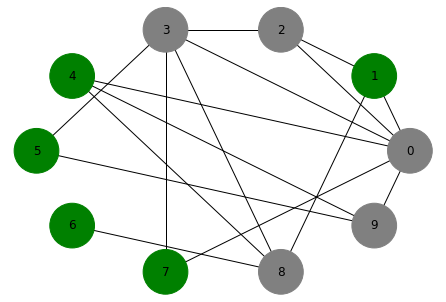

In [212]:
rand_output = compute_max_ind_set(rand_graph, display=True)

In [213]:
rand_output

[1, 4, 5, 6, 7]

## Generic Dataset Generator

Generates random graphs and compute their maximum independent set.  
Stores data in `data/generic_binomial`.  
Generates random graphs and stores them in individual files named as `binomial[ID].txt`, where `[ID]` is the ID of the graph. 
The ID ranges from 1 to n, where n is the size of the dataset.

A CSV would also be included in the directory. The format of this file would be rows of:  
```
filename, node1, node2, ... node[n]
```
The graph would be stored at `filename` and the solution would be presented as a list of nodes. Note that this only one solution specified in this training set, there might be other maximum solutions.


In [ ]:
root_dir = "data/generic_binomial"

